# Turbulent Channel (Reynolds 2003)

The simulation of a periodic turbulent channel is also used for validation of the equilibrium wall model implemented with the thin boundary layer (TBL) equation. A friction Reynolds number of 2003 is fixed for this case. The reference article used for comparison of results is [Han et al., 2020](https://iopscience.iop.org/article/10.1088/1873-7005/ac1782/meta). The pressure gradient is estabilished through a constant body force.

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/04.1_turbulent_channel_flow_wm.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

In [2]:
sim_cfg = next(
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if sim_cfg.name == "periodicTurbulentChannel"
)
sim_cfg_wm = next(
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if sim_cfg.name == "periodicTurbulentChannelMultilevel"
)
sim_cfg_wm_mb = next(
    sim_cfg
    for (name, _), sim_cfg in sim_cfgs.items()
    if sim_cfg.name == "periodicTurbulentChannelNoWM"
)
sim_cfgs_use = {"ref": sim_cfg, "wm": sim_cfg_wm, "mb": sim_cfg_wm_mb}

Functions to use for turbulence channel processing

In [3]:
import pandas as pd
import numpy as np
import pathlib
from nassu.cfg.schemes.simul import SimulationConfigs
from vtk.util.numpy_support import vtk_to_numpy
from tests.validation.notebooks import common


def get_experimental_profiles(reynolds_tau: float) -> dict[str, pd.DataFrame]:
    files_tau: dict[float, dict[str, str]] = {
        2003: {
            "ux": "Turbulent_channel/Re_tau_2003/u_avg.csv",
            "ux_rms": "Turbulent_channel/Re_tau_2003/u_rms.csv",
            "uy_rms": "Turbulent_channel/Re_tau_2003/v_rms.csv",
            "uz_rms": "Turbulent_channel/Re_tau_2003/w_rms.csv",
        },
    }

    files_get = files_tau[reynolds_tau]
    vals_exp: dict[str, pd.DataFrame] = {}
    for name, comp_file in files_get.items():
        filename = pathlib.Path("tests/validation/comparison") / comp_file
        df = pd.read_csv(filename, delimiter=",")
        vals_exp[name] = df
    return vals_exp


def get_height_scale(sim_cfg: SimulationConfigs, reynolds_tau: float, u_ref: float) -> float:
    kin_visc = sim_cfg.models.LBM.kinematic_viscosity
    return u_ref / kin_visc


reader_output = {}
for name, sim_cfg in sim_cfgs_use.items():
    stats_export = sim_cfg.output.stats["default"]
    last_step = stats_export.interval.get_all_process_steps(sim_cfg.n_steps)[-1]
    reader = stats_export.read_vtm_export(last_step)
    reader_output[sim_cfg.name] = reader.GetOutput()


def get_macr_compressed(
    sim_cfg: SimulationConfigs, macr_name: str, is_2nd_order: bool
) -> np.ndarray:
    global reader, reader_output

    output_use = reader_output[sim_cfg.name]

    macr_name_read = macr_name if not is_2nd_order else f"{macr_name}_2nd"
    ds = sim_cfg.domain.domain_size

    p0 = np.array((ds.x // 2, ds.y // 2, 4))
    p1 = np.array((ds.x // 2, ds.y // 2, ds.z // 2))
    n_points = ds.z - 8
    pos = np.linspace(p0, p1, num=n_points, endpoint=True)
    norm_pos = (pos[:, 2] - 4) / (ds.z - 8)

    # Sum 0.5 because data is cell centered in vtm

    line = common.create_line(p0, p1, n_points - 1)

    probe_filter = common.probe_over_line(line, output_use)
    probed_data = vtk_to_numpy(probe_filter.GetOutput().GetPointData().GetArray(macr_name_read))

    return np.array([norm_pos, probed_data])

In [4]:
y, ux_avg = get_macr_compressed(sim_cfg, "ux", is_2nd_order=False)

## Results

The average velocity profile is shown for the case. It can be seen a good approximation of desired profile when using the wall model.

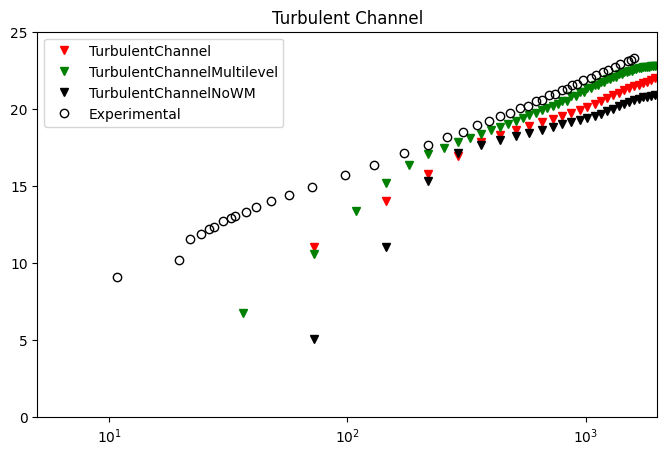

In [5]:
import matplotlib.pyplot as plt

reynolds_tau = 2003
u_ref = 0.0023

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 5)

for i, (sim_cfg, color) in enumerate(zip(sim_cfgs_use.values(), ("r", "g", "k"))):
    height_scale = get_height_scale(sim_cfg, reynolds_tau, u_ref)
    name = sim_cfg.name.removeprefix("periodic")

    analytical_values = get_experimental_profiles(reynolds_tau)

    y, ux_avg = get_macr_compressed(sim_cfg, "ux", is_2nd_order=False)
    if not sim_cfg.name.endswith("Multilevel"):
        y, ux_avg = y[::2], ux_avg[::2]

    ux_avg /= u_ref
    y *= height_scale * (sim_cfg.domain.domain_size.z - 8)

    exp_y = analytical_values["ux"]["y+"]
    exp_ux_avg = analytical_values["ux"]["u/u*"]

    ax.plot(y, ux_avg, f"v{color}", label=f"{name}")

ax.plot(exp_y, exp_ux_avg, "ok", label="Experimental", fillstyle="none")

ax.set_title("Turbulent Channel")

ax.legend(loc="upper left")
ax.set_xlim(5, 2000)
ax.set_ylim(0, 25)
ax.set_xscale("symlog")

The results of the ${\mathrm{u_{rms}}}$ velocity profiles shown below also indicate a good representation with the multilevel approach.

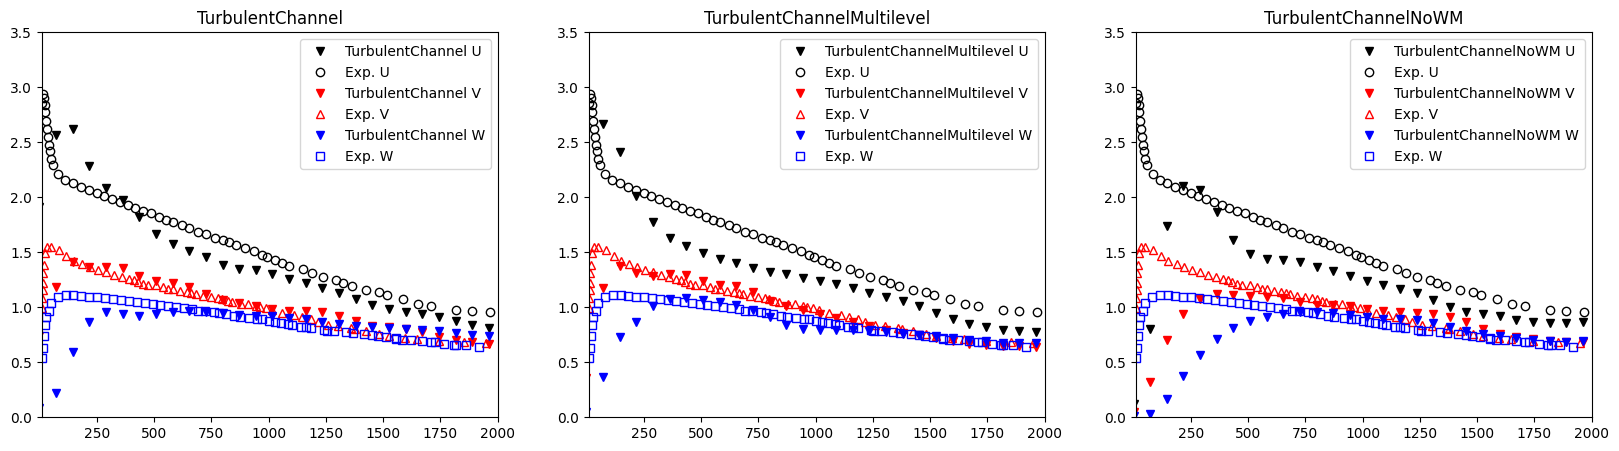

In [6]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 5)

vel_name_map = {"ux": "u", "uy": "v", "uz": "w"}

for i, sim_cfg in enumerate(sim_cfgs_use.values()):
    name = sim_cfg.name.removeprefix("periodic")
    for macr_name, marker, color in [("ux", "o", "k"), ("uy", "^", "r"), ("uz", "s", "b")]:
        macr_compr_rms = get_macr_compressed(sim_cfg, macr_name, is_2nd_order=True)
        macr_compr_avg = get_macr_compressed(sim_cfg, macr_name, is_2nd_order=False)

        y = macr_compr_rms[0].copy()
        vel_2nd = macr_compr_rms[1].copy()
        vel_avg = macr_compr_avg[1].copy()
        vel_rms = (vel_2nd - vel_avg**2) ** 0.5

        vel_rms /= u_ref
        y *= height_scale * (sim_cfg.domain.domain_size.z - 8)
        # Remove wall value
        vel_rms = vel_rms[::2]
        y = y[::2]

        name_vel = vel_name_map[macr_name]
        df = analytical_values[f"{macr_name}_rms"]
        exp_y = df["y+"]
        exp_rms = df[f"{name_vel}'/u*"]

        ax[i].plot(y, vel_rms, f"v{color}", label=f"{name} {name_vel.upper()}")
        ax[i].plot(
            exp_y, exp_rms, f"{marker}{color}", label=f"Exp. {name_vel.upper()}", fillstyle="none"
        )
        # ax[i].set_xscale("symlog")

    ax[i].set_title(f"{name}")

    ax[i].legend()
    ax[i].set_xlim(10, 2000)
    ax[i].set_ylim(0, 3.5)

It can be seen good approach of results with the use of wall model and subsequent combination with multigrid approach. As the shell point becomes nearer the surface for a high refinement, the first point velocity becomes a little smaller than for a coarser refinement.

## Version

In [7]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 09c9337ca174e12ce2cfa6eb39867054691a2742


## Configuration

In [8]:
from IPython.display import Code

Code(filename=filename)

simulations:
  - name: periodicTurbulentChannel
    save_path: ./tests/validation/results/04.1_turbulent_channel_flow_wm/periodic
    run_simul: true

    n_steps: 200000
    report:
      frequency: 1000

    domain:
      domain_size:
        x: 168
        y: 168
        z: 64 # spacing 56
      block_size: 8
      bodies:
        plane_floor:
          IBM:
            run: True
            cfg_use: plane_cfg
            order: 0
          lnas_path: fixture/lnas/wind_tunnel/full_plane.lnas
          transformation:
            scale: [2, 2, 2]
            translation: [0, 0, 4]
        plane_ceil:
          IBM:
            run: True
            cfg_use: plane_cfg
            order: 0
          lnas_path: fixture/lnas/wind_tunnel/full_plane.lnas
          transformation:
            scale: [2, 2, 2]
            fixed_point: [0, 80, 0]
            rotation: !math [radians(180), 0, 0]
            translation: [0, 0, 60]

    data:
      export_IBM_nodes:
        frequency: 5000
      divergence: { frequency: 1 }
      instantaneous:
        default: { interval: { frequency: 5000 }, macrs: [rho, u, omega_LES, f_IBM] }
      statistics:
        interval: { frequency: 100, start_step: 100000 }
        macrs_1st_order: [rho, u]
        macrs_2nd_order: [u]
        exports:
          default: { interval: { frequency: 50000 } }

    models:
      precision:
        default: single

      LBM:
        tau: 0.500096682620786
        F:
          x: 1.89820067659664E-07
          y: 0
          z: 0
        vel_set: D3Q27
        coll_oper: RRBGK
      initialization:
        vtm_filename: "../nassuArtifacts/macrs/turbulent_channel_wm.vtm"

      engine:
        name: CUDA

      LES:
        model: Smagorinsky
        sgs_cte: 0.17

      BC:
        periodic_dims: [true, true, true]

      IBM:
        dirac_delta: 3_points
        forces_accomodate_time: 0
        reset_forces: true
        body_cfgs:
          default:
            n_iterations: 1
            forces_factor: 1.0
          plane_cfg:
            n_iterations: 1
            forces_factor: 0.25
            wall_model:
              name: EqTBL
              dist_ref: 2.0
              dist_shell: 0.25
              start_step: 0
              params:
                z0: 0.00155
                TDMA_max_error: 1e-04
                TDMA_max_iters: 10
                TDMA_n_div: 51
            visc_correction: False

      multiblock:
        overlap_F2C: 2

  - name: periodicTurbulentChannelMultilevel
    parent: periodicTurbulentChannel
    run_simul: true

    domain:
      refinement:
        static:
          default:
            volumes_refine:
              - start: [0, 0, 0]
                end: [168, 168, 16]
                lvl: 1
                is_abs: true
              - start: [0, 0, 48]
                end: [168, 168, 64]
                lvl: 1
                is_abs: true

  - name: periodicTurbulentChannelNoWM
    parent: periodicTurbulentChannel
    run_simul: true

    models:
      IBM:
        body_cfgs:
          plane_cfg:
            wall_model: null